# Análisis de taxis requeridos

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, se necesita predecir la cantidad de pedidos de taxis para la próxima hora. Se construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Inicializacion y vista previa

In [1]:
# importar librerias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer 

from sklearn.linear_model import LinearRegression   
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
# cargar datos y establecer la columna 0 como datos de tipo datetime
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# información general
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


In [4]:
#vista previa
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
#rango de fechas de los datos
print('Rango de fechas disponible: ',df.index.min(),' - ', df.index.max())

Rango de fechas disponible:  2018-03-01 00:00:00  -  2018-08-31 23:50:00


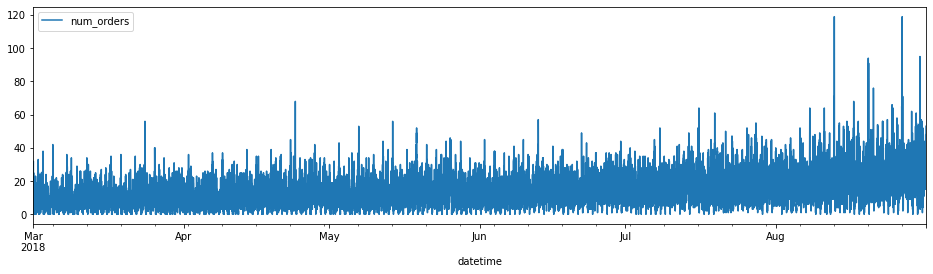

In [6]:
#grafica de los datos cada 10 minutos
df.plot(figsize=(16,4))
plt.show()

**Descripción de los datos**
- `datetime` - fecha y hora del muestreo
- `num_orders` - número de pedidos de taxis

Se tienen datos del 1 de marzo del 2018 al 31 de agosto del 2018.

No hay presencia de valores ausentes y las columnas son del tipo incorrecto.

Los datos estan muestreados cada 10 minutos, pero el análisis requiere los datos por hora. 

## Preprocesamiento  y análisis de los datos 
Se hace el remuestreo por hora.

In [7]:
# comprobar que las fechas estan en orden
df.index.is_monotonic

True

In [8]:
#remuestreo por hora
df = df.resample('1H').median()

In [9]:
# crear columna con media movil con tamaño de ventana de 24 (24 horas)
# se usa shift porque el valor actual de una fila no se puede utilizar para calcular la media móvil
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

In [10]:
#vista previa
df.sample(3)

,num_orders,rolling_mean
datetime,,
2018-08-08 22:00:00,15.5,17.937500
2018-04-23 01:00:00,11.0,10.833333
2018-05-01 09:00:00,10.5,10.541667


**Influencia del la hora en el número de pedidos**

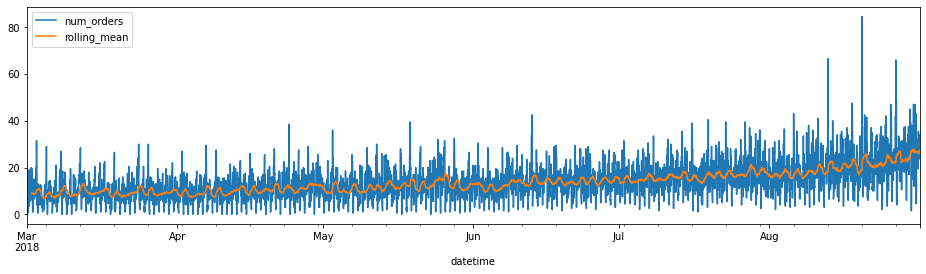

In [11]:
#grafica con remuestreo de 1 hora
df.plot(figsize=(16,4))
plt.show()

Descomponer los datos en tendencia, componente estacional y residuos

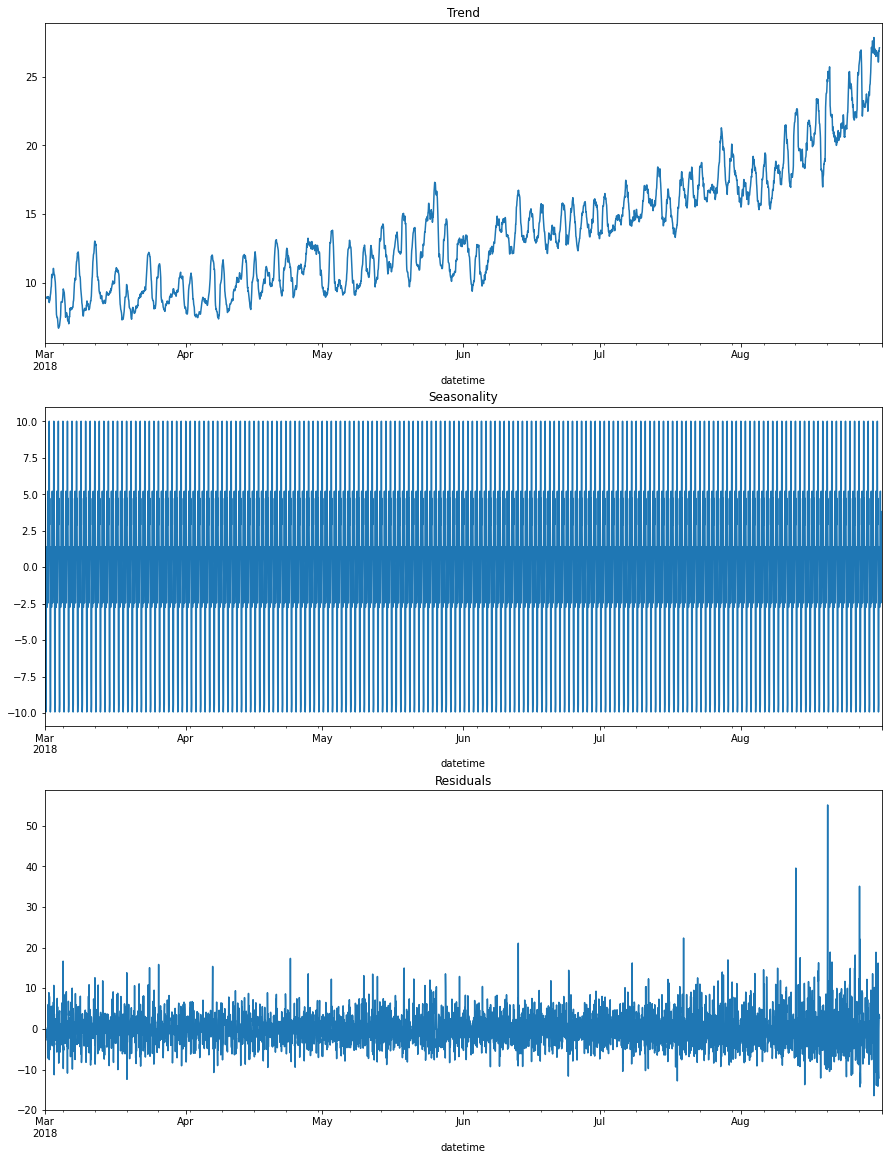

In [12]:
plt.figure(figsize=(15, 20))  

plt.subplot(311) # plt.subplot(311) = 3 filas, 1 columna, primera imagen
seasonal_decompose(df['num_orders']).trend.plot(ax=plt.gca())  # plt.gca() --> Get the current Axes 
plt.title('Trend')  

plt.subplot(312)  
seasonal_decompose(df['num_orders']).seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')  

plt.subplot(313)  
seasonal_decompose(df['num_orders']).resid.plot(ax=plt.gca())  
plt.title('Residuals') 

plt.show()

La primer gráfica muestra una tendencia positiva pues conforme pasan los meses, la cantidad de taxis pedidos incrementa. 

La gráfica del componente estacional oscila alrededor de cero, por lo que se necesitaría un periodo de tiempo más largo para obtener información estacionaria.

La gráfica de los residuos o ruido muestran los valores atípicos los cuales incrementan significativamente en el mes de Agosto.

In [13]:
df.groupby(df.index.hour)['num_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
0,184.0,23.608696,8.210791,6.5,17.375,22.50,28.000,47.5
1,184.0,16.510870,8.231447,3.0,11.000,15.00,19.625,48.0
2,184.0,18.304348,11.316354,2.0,10.000,17.00,24.000,84.5
3,184.0,16.442935,7.406854,3.0,10.500,15.50,20.500,43.5
4,184.0,13.932065,8.795305,0.5,6.500,13.25,19.000,49.0
5,184.0,6.103261,4.505333,0.0,2.000,5.00,9.125,19.5
6,184.0,3.701087,3.536739,0.0,1.000,2.50,5.500,16.0
7,184.0,4.239130,2.852454,0.0,2.000,3.50,6.000,15.0
8,184.0,11.940217,3.891874,4.0,9.500,11.50,14.125,27.0


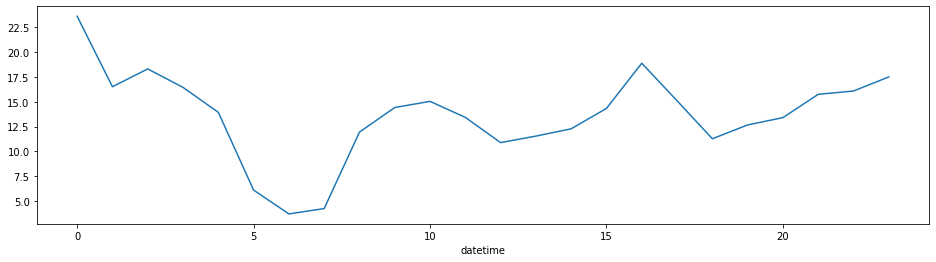

In [14]:
df.groupby(df.index.hour)['num_orders'].mean().plot(figsize=(16,4))
plt.show()

Alrededor de las 6 y 7 de la mañana, se requiere el menor número de taxis. 

Alrededor de las 11pm hasta las 3am es donde más taxis se requieren. Este comportamiento es similar a las 4pm.

**Influencia del mes en el número de pedidos**

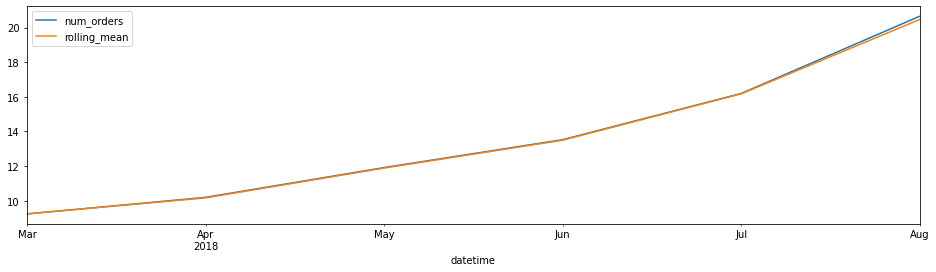

In [15]:
#grafica de muestreo por mes
df.resample('M').mean().plot(figsize=(16,4))
plt.show()

In [16]:
#valores máximos por mes
df.resample('M')['num_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2018-03-31,744.0,9.237903,5.101380,0.0,6.0,8.50,12.0,31.5
2018-04-30,720.0,10.193056,5.469878,0.0,7.0,10.00,13.5,38.5
2018-05-31,744.0,11.913306,6.110210,0.0,8.0,11.50,15.5,39.5
2018-06-30,720.0,13.524306,5.688705,1.0,10.0,13.50,17.0,42.5
2018-07-31,744.0,16.192204,6.429660,1.0,12.0,15.75,20.0,40.5
2018-08-31,744.0,20.651882,9.399775,1.5,14.5,20.00,26.0,84.5


Conforme pasa el año, el número de pedidos de taxis va incrementando. Incluso, la cantidad del mes de agosto, mes final, duplica la de marzo, el mes inicial.

## Formación

Se crean características para el pronóstico y se entrenan diferentes modelos con diferentes hiperparámetros.

**Crear características para el pronóstico**

Se exploran las siguientes características para los modelos predictivos, a excepción del modelo constante.
- características del calendario: mes, día del mes y día de la semana
- características de desfase: usa valores anteriores para saber si los pedidos aumentaran o disminuiran
- característica de media móvil: establece la tendencia general de la serie temporal

In [17]:
# Crear características del calendario   
df['month'] = df.index.month
#df['week'] = df.index.isocalendar().week
df['day'] =   df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] =  df.index.hour

In [18]:
#desfase máximo
max_lag = 5

# Crear características de desfase
for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag) 

In [19]:
#vista previa
df.head(20)

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,
2018-03-01 00:00:00,20.5,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,14.5,NaN,3,1,3,1,20.5,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,10.0,NaN,3,1,3,2,14.5,20.5,NaN,NaN,NaN
2018-03-01 03:00:00,9.0,NaN,3,1,3,3,10.0,14.5,20.5,NaN,NaN
2018-03-01 04:00:00,4.0,NaN,3,1,3,4,9.0,10.0,14.5,20.5,NaN
2018-03-01 05:00:00,0.5,NaN,3,1,3,5,4.0,9.0,10.0,14.5,20.5
2018-03-01 06:00:00,1.5,NaN,3,1,3,6,0.5,4.0,9.0,10.0,14.5
2018-03-01 07:00:00,1.5,NaN,3,1,3,7,1.5,0.5,4.0,9.0,10.0
2018-03-01 08:00:00,5.5,NaN,3,1,3,8,1.5,1.5,0.5,4.0,9.0


**Separar datos en conjunto de prueba y entrenamiento**

La muestra de prueba se hace con el 10% del conjunto de datos inicial.

In [20]:
# eliminar valores ausentes
df = df.dropna() 

In [21]:
#objeto TimeSeriesSplit para la optimización de hiperparámetros
tss = TimeSeriesSplit(n_splits = 3) 

In [22]:
#separar características de objetivo
features = df.drop(['num_orders'],axis=1)
target = df['num_orders']

#separar conjunto de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

In [23]:
print('train shape: ', features_train.shape)
print('test shape: ', features_test.shape)

train shape:  (3952, 10)

test shape:  (440, 10)


In [24]:
#comprobar que el conjunto de datos de entrenamiento son de fechas anteriores al conjunto de datos de prueba
print('Rango de fechas del conjunto de entrenamiento: ', features_train.index.min(),' - ', features_train.index.max()) 
print('Rango de fechas del conjunto de prueba:        ', features_test.index.min(), ' - ',features_test.index.max()) 

Rango de fechas del conjunto de entrenamiento:  2018-03-02 00:00:00  -  2018-08-13 15:00:00

Rango de fechas del conjunto de prueba:         2018-08-13 16:00:00  -  2018-08-31 23:00:00


### Modelo predictivo constante

Todos los valores de la muestra de prueba se pronostican con el mismo número (una constante) que es la mediana del conjunto de datos de entrenamiento.

In [25]:
#obtener constante predictiva
print('Mediana de cantidad de pedidos de taxis por hora (cantidad real):',df['num_orders'].median())
print()
print('Mediana de cantidad de pedidos de taxis por hora (media movil):',df['rolling_mean'].median())

Mediana de cantidad de pedidos de taxis por hora (cantidad real): 12.5



Mediana de cantidad de pedidos de taxis por hora (media movil): 12.9375


### Modelo Regresión lineal

In [26]:
#crear modelo y entrenarlo
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

### Modelo árbol de decisión

In [27]:
#usar GridSearchCV para encontrar la mejor profundidad de árbol
param_grid = {'max_depth': [1,2,4,6,8,10]}

tree_reg = DecisionTreeRegressor(random_state=12345)
grid_search_dtr = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=tss, verbose=True, 
                               scoring='neg_root_mean_squared_error')

grid_search_dtr.fit(features_train, target_train)
grid_search_dtr.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


DecisionTreeRegressor(max_depth=6, random_state=12345)

In [28]:
#fijar modelo con parámetros encontrados
model_dtr = DecisionTreeRegressor(max_depth=6, random_state=12345)

#entrenar modelo
model_dtr.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=6, random_state=12345)

### Modelo bosque aleatorio de decisión

In [29]:
#buscar las mejores características para los datos disponibles
param_grid = {'n_estimators': [1,2,3,4,6,8,10],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10]}

model_rfr =RandomForestRegressor(random_state=12345)
grid_search_rfr = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=tss, scoring='neg_root_mean_squared_error')

grid_search_rfr.fit(features_train, target_train)
grid_search_rfr.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}

In [30]:
#fijar modelo con parámetros encontrados
model_rfr =RandomForestRegressor(random_state=12345, max_depth=10, max_features='sqrt', n_estimators=10)

#entrenar modelo
model_rfr.fit(features_train, target_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=10,
                      random_state=12345)

### Modelo CatBoost Regressor

In [31]:
#buscar las mejores características para los datos disponibles
param_cb={'depth':[4, 6, 8, 10], 'learning_rate':[0.5, 0.1], 'iterations':[10, 30, 50, 100], 'loss_function':['RMSE']}

model_cb=CatBoostRegressor(random_seed=123456, verbose=False)
grid=GridSearchCV(estimator=model_cb, param_grid=param_cb, cv=tss, n_jobs=-1, scoring='neg_root_mean_squared_error')

grid.fit(features_train, target_train)
grid.best_params_

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'RMSE'}

In [32]:
#fijar el modelo
model_cbr = CatBoostRegressor(random_seed=123456, verbose=False, depth=6, iterations=100, learning_rate=0.1, 
                              loss_function='RMSE')

#entrenar modelo
model_cbr.fit(features_train, target_train)

### Modelo LGBM Regressor

In [33]:
#buscar las mejores características para los datos disponibles
param_ltb={'num_leaves':[10, 15, 20], 'learning_rate':[0.5, 0.1], 'n_estimators':[10, 20, 30], 'objective':['rmse']}

model_ltb = LGBMRegressor(random_seed=123456)
grid = GridSearchCV(estimator=model_ltb, param_grid=param_ltb, cv=tss, n_jobs=-1, scoring='neg_root_mean_squared_error')

grid.fit(features_train, target_train)
grid.best_params_

{'learning_rate': 0.1,
 'n_estimators': 30,
 'num_leaves': 20,
 'objective': 'rmse'}

In [34]:
#fijar el modelo
model_ltb = LGBMRegressor(random_seed=123456, learning_rate=0.1, n_estimators=30, num_leaves=20, objective='rmse')

#entrenar modelo
model_ltb.fit(features_train, target_train)

LGBMRegressor(n_estimators=30, num_leaves=20, objective='rmse',
              random_seed=123456)

## Prueba

Se prueban los datos usando los distitnos modelos aplicados en la muestra de prueba.

Se establece la raiz del error cuadratico medio (RMSE) como métrica de evaluación. Mientras el valor RMSE sea más chico, mejor es el modelo.

### Modelo predictivo constante

In [35]:
#calcular metrica RECM con mediana
pred_constant1 = np.ones(target_test.shape[0]) * df['num_orders'].median()

c_train_rmse = mean_squared_error(target_test, pred_constant1, squared=False)
print('RECM: ', c_train_rmse)

RECM:  14.036336772819325


In [36]:
#calcular metrica RECM con media movil
pred_constant2 =  np.ones(target_test.shape[0]) * df['rolling_mean'].median()

c_test_rmse =  mean_squared_error(target_test, pred_constant2, squared=False)
print('RECM: ', c_test_rmse)

RECM:  13.727246152517926


### Modelo regresión lineal

In [37]:
#predicciones en conjunto de entrenamiento y prueba
pred_train_lr = model_lr.predict(features_train) 
pred_test_lr = model_lr.predict(features_test) 

In [38]:
#calcular metrica RECM
lr_train_rmse = mean_squared_error(target_train, pred_train_lr, squared=False)
lr_test_rmse = mean_squared_error(target_test, pred_test_lr, squared=False)

print('RECM para el conjunto de entrenamiento: ',  lr_train_rmse)
print('RECM para el conjunto de prueba:        ',  lr_test_rmse)

RECM para el conjunto de entrenamiento:  5.37338833727688

RECM para el conjunto de prueba:         8.880518365948838


### Modelo árbol de decisión

In [39]:
#predicciones en conjunto de entrenamiento y prueba
pred_train_dtr = model_dtr.predict(features_train) 
pred_test_dtr = model_dtr.predict(features_test) 

In [40]:
#calcular metrica RECM
dtr_train_rmse = mean_squared_error(target_train, pred_train_dtr, squared=False)
dtr_test_rmse = mean_squared_error(target_test, pred_test_dtr, squared=False)

print('RECM para el conjunto de entrenamiento: ', dtr_train_rmse)
print('RECM para el conjunto de prueba:        ', dtr_test_rmse)

RECM para el conjunto de entrenamiento:  4.156032655937512

RECM para el conjunto de prueba:         8.948318830624258


### Modelo bosque aleatorio de decisión

In [41]:
#predicciones en conjunto de entrenamiento y prueba
pred_train_rfr = model_rfr.predict(features_train) 
pred_test_rfr = model_rfr.predict(features_test) 

In [42]:
#calcular metrica RECM
rfr_train_rmse = mean_squared_error(target_train, pred_train_rfr, squared=False)
rfr_test_rmse = mean_squared_error(target_test, pred_test_rfr, squared=False)

print('RECM para el conjunto de entrenamiento: ', rfr_train_rmse)
print('RECM para el conjunto de prueba:        ', rfr_test_rmse)

RECM para el conjunto de entrenamiento:  3.132332137586037

RECM para el conjunto de prueba:         8.68852229855589


### Modelo CatBoost Regressor

In [43]:
#predicciones en conjunto de entrenamiento y prueba
pred_train_cbr = model_cbr.predict(features_train) 
pred_test_cbr = model_cbr.predict(features_test) 

In [44]:
#calcular metrica RECM
cbr_train_rmse = mean_squared_error(target_train, pred_train_cbr, squared=False)
cbr_test_rmse = mean_squared_error(target_test, pred_test_cbr, squared=False)

print('RECM para el conjunto de entrenamiento: ', cbr_train_rmse)
print('RECM para el conjunto de prueba:        ', cbr_test_rmse)

RECM para el conjunto de entrenamiento:  3.575831020687962

RECM para el conjunto de prueba:         8.153725089033816


### Modelo LGBM Regressor

In [45]:
#predicciones en conjunto de entrenamiento y prueba
pred_train_ltb = model_ltb.predict(features_train) 
pred_test_ltb = model_ltb.predict(features_test) 

In [46]:
#calcular metrica RECM
ltb_train_rmse = mean_squared_error(target_train, pred_train_ltb, squared=False)
ltb_test_rmse = mean_squared_error(target_test, pred_test_ltb, squared=False)

print('RECM para el conjunto de entrenamiento: ', ltb_train_rmse)
print('RECM para el conjunto de prueba:        ', ltb_test_rmse)

RECM para el conjunto de entrenamiento:  3.692284772033667

RECM para el conjunto de prueba:         8.362329245321405


## Conclusión

Tabla comparativa de los valores RMSE por modelo

In [47]:
#Tabla con los valores RMSE de los modelos
table = pd.DataFrame({'Model':['Constant', 'Linear Regression','Decision Tree Regressor','Random Forest Regressor',
                               'CatBoost Regressor', 'LGBM Regressor'],
'RMSE training set': [c_train_rmse, lr_train_rmse, dtr_train_rmse, rfr_train_rmse, cbr_train_rmse, ltb_train_rmse],
'RMSE test set':     [c_test_rmse, lr_test_rmse, dtr_test_rmse, rfr_test_rmse, cbr_test_rmse, ltb_test_rmse]})

table.sort_values('RMSE test set')

,Model,RMSE training set,RMSE test set
4,CatBoost Regressor,3.575831,8.153725
5,LGBM Regressor,3.692285,8.362329
3,Random Forest Regressor,3.132332,8.688522
1,Linear Regression,5.373388,8.880518
2,Decision Tree Regressor,4.156033,8.948319
0,Constant,14.036337,13.727246


Tras buscar los mejores parámetros de cada modelo, en todos se obtuvo un valor RMSE menor al requerido (48), incluso al tomar la mediana como el valor predictivo.

Al comparar los modelos usados, se recomiendan los primeros tres:
- CatBoost Regressor
- LGBM Regressor
- Random Forest Regressor

Estos tres modelos tienen resultados similares tanto en el valor RMSE del conjunto de entrenamiento como en el de prueba.